In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np

import random
import operator
import pickle

In [2]:
def DCG_score(y_true, y_pred, n=5):
    y_true = y_true / y_true.max()
    y_pred = y_pred / y_pred.max()
    
    n = min(len(y_true), n)
    index = np.argsort(y_pred)[::-1][:n]
    y_top = y_true[index]
    
    numerator   = 2 ** y_top - 1
    denominator = np.log2(1 + np.arange(1, n+1))
    return np.sum(numerator / denominator)

def NDCG_score(y_true, y_pred, n=5): 
    n = min(len(y_true), n)
    best = DCG_score(y_true, y_true, n)
    curr = DCG_score(y_true, y_pred, n)
    return curr / best

def delta_NDCG_score(y_true, y_pred, n=5):
    y_true = y_true / y_true.max()
    y_pred = y_pred / y_pred.max()
    
    n = min(len(y_true), n)
    DCG_best = DCG_score(y_true, y_true, n)
    
    index = np.argsort(y_true)[::-1]
    order = np.zeros(len(y_true))
    order[index] = np.arange(1, len(y_true)+1)
    
    numerator   = 2 ** y_true - 1
    denominator = np.log2(1 + order)
    
    # DCG - DCG_swaped = (i <= n) * a_ii + (j <= n) * a_jj - (i <= n) * a_ij - (j <= n) * a_ji
    
    doc_correct = np.tile(numerator / denominator, (len(y_true), 1)).T
    doc_swaped = numerator.reshape(1, -1) / denominator.reshape(-1, 1)
    
    doc_correct[(order > n)] = 0
    doc_swaped[(order > n)] = 0
    
    delta_DCG = np.abs(doc_correct + doc_correct.T - doc_swaped - doc_swaped.T)
    return delta_DCG / DCG_best 

In [3]:
def rank_wrong_pairs(y_true, y_pred):
    pairs_true = (y_true.reshape(-1, 1) - y_true.reshape(1, -1)) <= 0
    pairs_pred = (y_pred.reshape(-1, 1) - y_pred.reshape(1, -1)) <= 0
    return (pairs_true != pairs_pred).sum()

In [4]:
df = pd.read_csv("data/train.data.csv", sep=',')

In [5]:
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X128,X129,X130,X131,X132,X133,X134,X135,X136,QID
0,21973.30000,3,3,0,0,3,1.0,1.0,0.000000,0.0,...,11089534,2,116,64034,13,3,0,0,0.0,1
1,21973.30000,3,0,3,0,3,1.0,0.0,1.000000,0.0,...,11089534,2,124,64034,1,2,0,0,0.0,1
2,1.09861,3,0,2,0,3,1.0,0.0,0.666667,0.0,...,3,1,124,3344,14,67,0,0,0.0,1
3,21973.30000,3,0,3,0,3,1.0,0.0,1.000000,0.0,...,11089534,13,123,63933,1,3,0,0,0.0,1
4,10987.20000,3,0,3,0,3,1.0,0.0,1.000000,0.0,...,5,7,256,49697,1,13,0,0,0.0,1


In [6]:
df_mean = df.mean().values[1:-1].reshape(1, -1)

In [7]:
df_grouped = df.groupby(by="QID")

In [8]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped {} bytes>".format(size))
    return strip_def

  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:950px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [9]:
def get_lambda_vector(h, y, sigma):
    h = h.reshape(-1)
    y = y.reshape(-1)

    delta_h = h.reshape((-1, 1)) - h.reshape((1, -1))
    sign_y = np.sign(y.reshape((-1, 1)) - y.reshape(1, -1))
    lambda_matrix = -sigma / (1 + np.exp(sigma * delta_h * sign_y))
    # lambda_matrix = -sigma / (1 + np.exp(sigma * delta_h))
    # lambda_matrix *= delta_NDCG_score(y, h, n=5)    
    lambda_matrix = (lambda_matrix * sign_y).sum(axis=1).reshape(-1)
    return lambda_matrix

In [10]:
class LambdaRank:
    n_features = 136
    n_batch = 50
    
    sigma = 1.0
    lr = 0.0001
    
    def __init__(self):
        tf.reset_default_graph()
        
        with tf.name_scope("input"):
            self.net_in = tf.placeholder(tf.float32, shape=(self.n_batch, self.n_features), name="x")
            prev = tf.nn.sigmoid(tf.sub(self.net_in, df_mean))
            # prev = self.net_in
        
        self.weights = []
        self.weights_update_op = []
        self.weights_update_pl = []
        
        prev = self.seq_layer("layer_01", prev, dim_out=64, activation="sigmoid")
        prev = self.seq_layer("layer_02", prev, dim_out=1, activation="sigmoid")
        
        self.net_out = prev
        
        self.gradients_count_op = []
        with tf.name_scope("gradients"):
            for param_n, param in enumerate(self.weights):
                grads = [tf.gradients(ys=yi, xs=[param])[0] for yi in tf.unstack(prev, axis=0)]
                grads = tf.stack(grads)
                self.gradients_count_op.append(grads)
                
        self.sess = tf.Session()
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
    
    def seq_layer(self, name, prev, dim_out, activation="sigmoid"):
        dim_in = int(prev.get_shape()[1])
    
        with tf.name_scope(name):    
            weights = tf.Variable(tf.random_normal([dim_in, dim_out], stddev=0.01), name="W")
            bias = tf.Variable(tf.random_normal([dim_out], stddev=0.01), name="b")
            
            arg = tf.placeholder(tf.float32, shape=[dim_in, dim_out], name="W_grad")
            op = tf.assign_sub(ref=weights, value=arg, name="W_update")
            self.weights_update_pl.append(arg)
            self.weights_update_op.append(op)
                
            arg = tf.placeholder(tf.float32, shape=[dim_out], name="b_grad")
            op = tf.assign_sub(ref=bias, value=arg, name="b_update")
            self.weights_update_pl.append(arg)
            self.weights_update_op.append(op)
            
            self.weights.extend([weights, bias])
        
            prev = tf.nn.bias_add(tf.matmul(prev, weights, name="weights"), bias, name="bias")
            active_func = {
                "sigmoid": tf.nn.sigmoid,
                "relu":    tf.nn.relu,
                "tanh":    tf.nn.tanh
            }[activation]
            prev = active_func(prev, name=activation)

        return prev
    
    @staticmethod
    def plot_graph():
        show_graph(tf.get_default_graph())
    
    def get_output_and_gradients(self, x_values):
        result = None
        
        for i in range(0, len(x_values), self.n_batch):
            batch = x_values[i:i+self.n_batch]
            batch_size = len(batch)
            if batch_size < self.n_batch:
                batch = np.concatenate((
                    batch,
                    np.zeros(shape=(self.n_batch - batch_size, self.n_features))
                ), axis=0)
            
            out = self.sess.run([self.net_out] + self.gradients_count_op, feed_dict={self.net_in: batch})
            if batch_size < self.n_batch:
                out = [o[:batch_size] for o in out]
        
            if result is None:
                result = out
            else:
                for i in range(len(result)):
                    result[i] = np.concatenate((result[i], out[i]), axis=0)
        
        return result
    
    @staticmethod
    def count_new_gradients(gradients, lambdas):
        grads = [gradients[i] * lambdas[i] for i in range(len(lambdas))]
        grads = np.sum(grads, axis=0)
        return grads
    
    def apply_new_gradients(self, gradients, lr=0.01):
        for i in range(len(gradients)):
            self.sess.run(
                self.weights_update_op[i],
                feed_dict={self.weights_update_pl[i]: lr * gradients[i]}
            )
            
    def fit_query(self, X, Y):        
        output = self.get_output_and_gradients(X)
        h = output[0].reshape(-1)
        
        lambdas = get_lambda_vector(h, Y, self.sigma)
        gradients = [LambdaRank.count_new_gradients(grad, lambdas) for grad in output[1:]]
        self.apply_new_gradients(gradients, self.lr)
        
    def predict_query(self, X):
        result = None
        
        for i in range(0, len(X), self.n_batch):
            batch = X[i:i+self.n_batch]
            batch_size = len(batch)
            if batch_size < self.n_batch:
                batch = np.concatenate((
                    batch,
                    np.zeros(shape=(self.n_batch - batch_size, self.n_features))
                ), axis=0)
            
            out = self.sess.run(self.net_out, feed_dict={self.net_in: batch})
            if batch_size < self.n_batch:
                out = out[:batch_size]
        
            if result is None:
                result = out
            else:
                result = np.concatenate((result, out), axis=0)
        
        return result

In [11]:
lambdaRank = LambdaRank()

In [12]:
lambdaRank.plot_graph()

In [13]:
df_grouped = list(df_grouped)
n_total = len(df_grouped)
n_total

6000

In [14]:
random.shuffle(df_grouped)

In [15]:
border = int(0.8 * n_total)
df_train, df_valid = df_grouped[:border], df_grouped[border:]
n_train, n_valid = len(df_train), len(df_valid)

In [16]:
scores, pairs = [], []

In [17]:
with open("./stats/scores.pkl", "r") as f_name:
    scores = pickle.load(f_name)
    
with open("./stats/pairs.pkl", "r") as f_name:
    pairs = pickle.load(f_name)

In [18]:
saver = tf.train.Saver(lambdaRank.weights)

In [19]:
saver.restore(lambdaRank.sess, "./models/model_epoch_{:03}.ckpt".format(150))

In [20]:
for i, (score, pair) in enumerate(zip(scores, pairs)):
    print u"\r[{:03}] wrp(train) = {:>8} wrp(valid) = {:>7} ".format(i+1, *pair) + \
        u"NDCG(train) = {:>0.5f} NDCG(valid) = {:>0.5f}".format(*score)

for i in range(len(scores), 300):
    # fit
    for j, (name, group) in enumerate(df_train):
#         index = np.random.choice(len(group), size=min(len(group), 50), replace=False)
#         x_train, y_train = group.values[index, 1:-1], group.values[index, 0].reshape(-1)
        x_train, y_train = group.values[:, 1:-1], group.values[:, 0].reshape(-1)
        lambdaRank.fit_query(x_train, y_train)
        if (j + 1) % 50 == 0:
            print u"\r{} of {} queries are fitted...".format(j + 1, n_train),
    print u"\r{} of {} queries are fitted...".format(j + 1, n_train),
    
    # predict train
    counts = 0
    
    wrong_pairs_train, score_train = 0, 0
    
    for name, group in df_train:
        y_pred = lambdaRank.predict_query(group.values[:, 1:-1]).reshape(-1)
        y_true = group.values[:, 0].reshape(-1)
        
        wrong_pairs_train += rank_wrong_pairs(y_true, y_pred)
        score_train += NDCG_score(y_true, y_pred)
        
        counts += 1
        if counts % 100 == 0:
            print u"\r{} of {} queries are validated...".format(counts, n_total),
    score_train /= len(df_train)
    print u"\r{} of {} queries are validated...".format(counts, n_total),
    
    # predict valid
    wrong_pairs_valid, score_valid = 0, 0
    
    for name, group in df_valid:
        y_pred = lambdaRank.predict_query(group.values[:, 1:-1]).reshape(-1)
        y_true = group.values[:, 0].reshape(-1)
        
        wrong_pairs_valid += rank_wrong_pairs(y_true, y_pred)
        score_valid += NDCG_score(y_true, y_pred)
        
        counts += 1
        if counts % 100 == 0:
            print u"\r{} of {} queries are validated...".format(counts, n_total),
    score_valid /= len(df_valid)
    print u"\r{} of {} queries are validated...".format(counts, n_total),
        
    pairs.append((wrong_pairs_train, wrong_pairs_valid))
    scores.append((score_train, score_valid))
    
    print u"\r[{:03}] wrp(train) = {:>8} wrp(valid) = {:>7} ".format(i+1, *pairs[-1]) + \
        u"NDCG(train) = {:>0.5f} NDCG(valid) = {:>0.5f}".format(*scores[-1])
        
    if (i + 1) % 10 == 0:
        saver.save(lambdaRank.sess, "./models/model_epoch_{:03}.ckpt".format(i+1))
    
    if i + 1 > 15:
        pairs_ = np.asarray(map(operator.itemgetter(1), pairs[-5:]))
        scores_ = np.asarray(map(operator.itemgetter(1), scores[-5:]))
        if (pairs_[-1] > pairs_[:-1]).all() and (scores_[-1] < scores[:-1]).all():
            break


[001] wrp(train) = 42877467 wrp(valid) = 8671458 NDCG(train) = 0.39599 NDCG(valid) = 0.40693
[002] wrp(train) = 42706056 wrp(valid) = 8631041 NDCG(train) = 0.41388 NDCG(valid) = 0.42278
[003] wrp(train) = 42529890 wrp(valid) = 8590028 NDCG(train) = 0.43323 NDCG(valid) = 0.44370
[004] wrp(train) = 42407238 wrp(valid) = 8561488 NDCG(train) = 0.44316 NDCG(valid) = 0.45479
[005] wrp(train) = 42337700 wrp(valid) = 8544542 NDCG(train) = 0.44752 NDCG(valid) = 0.45578
[006] wrp(train) = 42279156 wrp(valid) = 8532985 NDCG(train) = 0.45047 NDCG(valid) = 0.46087
[007] wrp(train) = 42233193 wrp(valid) = 8522110 NDCG(train) = 0.45156 NDCG(valid) = 0.46191
[008] wrp(train) = 42196587 wrp(valid) = 8513501 NDCG(train) = 0.45280 NDCG(valid) = 0.46349
[009] wrp(train) = 42167794 wrp(valid) = 8506119 NDCG(train) = 0.45255 NDCG(valid) = 0.46333
[010] wrp(train) = 42139203 wrp(valid) = 8500125 NDCG(train) = 0.45274 NDCG(valid) = 0.46180
[011] wrp(train) = 42112328 wrp(valid) = 8495928 NDCG(train) = 0.45329

In [ ]:
raise NameException()

with open("./stats/scores.pkl", "w") as f_name:
    pickle.dump(scores, f_name)
    
with open("./stats/pairs.pkl", "w") as f_name:
    pickle.dump(pairs, f_name)

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

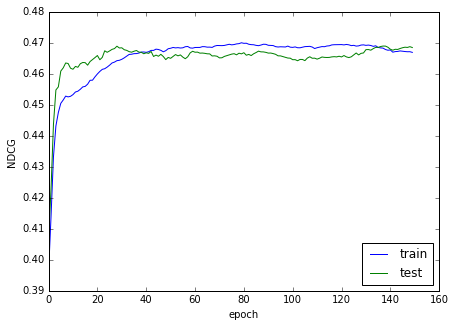

In [22]:
plt.figure(figsize=(7, 5))
plt.plot(map(operator.itemgetter(0), scores), label="train")
plt.plot(map(operator.itemgetter(1), scores), label="test")
plt.xlabel("epoch")
plt.ylabel("NDCG")
plt.legend(loc='lower right')
plt.show()

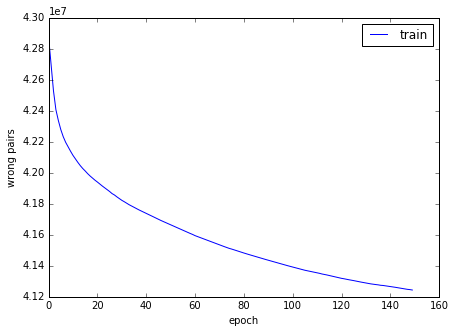

In [23]:
plt.figure(figsize=(7, 5))
plt.plot(map(operator.itemgetter(0), pairs), label="train", color="blue")
# plt.plot(map(operator.itemgetter(1), pairs), label="test", color="green")
plt.xlabel("epoch")
plt.ylabel("wrong pairs")
plt.legend(loc='upper right')
plt.show()

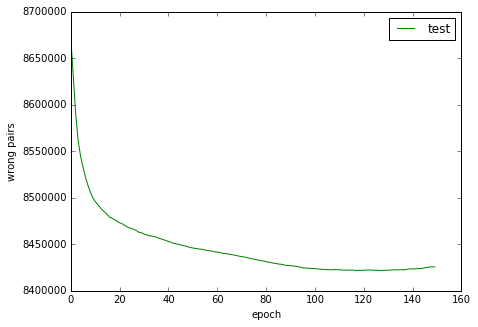

In [24]:
plt.figure(figsize=(7, 5))
# plt.plot(map(operator.itemgetter(0), pairs), label="train", color="blue")
plt.plot(map(operator.itemgetter(1), pairs), label="test", color="green")
plt.xlabel("epoch")
plt.ylabel("wrong pairs")
plt.legend(loc='upper right')
plt.show()

In [25]:
df = pd.read_csv("data/test.data.csv", sep=',')

In [26]:
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X128,X129,X130,X131,X132,X133,X134,X135,X136,QID
0,-1,2,0,2,1,2,1.0,0.0,1.0,0.5,...,1,0,266,25070,28,7,0,0,0.0,13
1,-1,2,0,0,0,2,1.0,0.0,0.0,0.0,...,93,0,153,12860,65,158,0,0,0.0,13
2,-1,2,0,1,0,2,1.0,0.0,0.5,0.0,...,0,0,153,1131,112,141,0,0,0.0,13
3,-1,2,0,2,1,2,1.0,0.0,1.0,0.5,...,81775,0,560,61224,1,14,0,0,0.0,13
4,-1,1,0,0,0,1,0.5,0.0,0.0,0.0,...,0,0,57953,15600,15,12,0,0,0.0,13


In [27]:
df_grouped_test = df.groupby(by="QID")

In [28]:
result = []

for name, group in df_grouped_test:
    x_test = group.values[:, 1:-1]
    y_pred = lambdaRank.predict_query(x_test).reshape(-1)
    order = sorted(zip(group.index, y_pred), key=operator.itemgetter(1), reverse=True)
    order = map(operator.itemgetter(0), order)
    order = [(index + 1, name) for index in order]
    result.extend(order)

In [ ]:
submission = pd.DataFrame(result, columns=["DocumentId", "QueryId"])
submission.to_csv("submission_5_{:03}.csv".format(i), sep=',', index=False)